In [1]:
# Import essential libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import copy 
import os 
import torch
from PIL import Image 
from torch.utils.data import Dataset 
import torchvision
import torchvision.transforms as transforms 
from torch.optim.lr_scheduler import ReduceLROnPlateau  
import torch.nn as nn 
from torchvision import utils 
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools 
from tqdm.notebook import trange, tqdm 
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#FFFFFF','#FF5733']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = '''
div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s;
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s;
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s;
    border-top: 2px solid %s;
}

div.input_prompt {
color: %s;
}

div.output_prompt {
color: %s; 
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s;
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s;
}

.edit_mode div.cell.selected:before {
background: %s;
}

.edit_mode div.cell.selected {
border-color: %s;

}
'''

def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, 
                                            main_color,  main_color, prompt, main_color, main_color, 
                                            main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

In [3]:
# Define Transformation
transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("archive (1)/archive (1)/train", transform=transform)
var1 = train_set.transform
val_set = torchvision.datasets.ImageFolder("archive (1)/archive (1)/valid", transform=transform)
var2 = val_set.transform
test_set = torchvision.datasets.ImageFolder("archive (1)/archive (1)/test", transform=transform)
var3 = test_set.transform

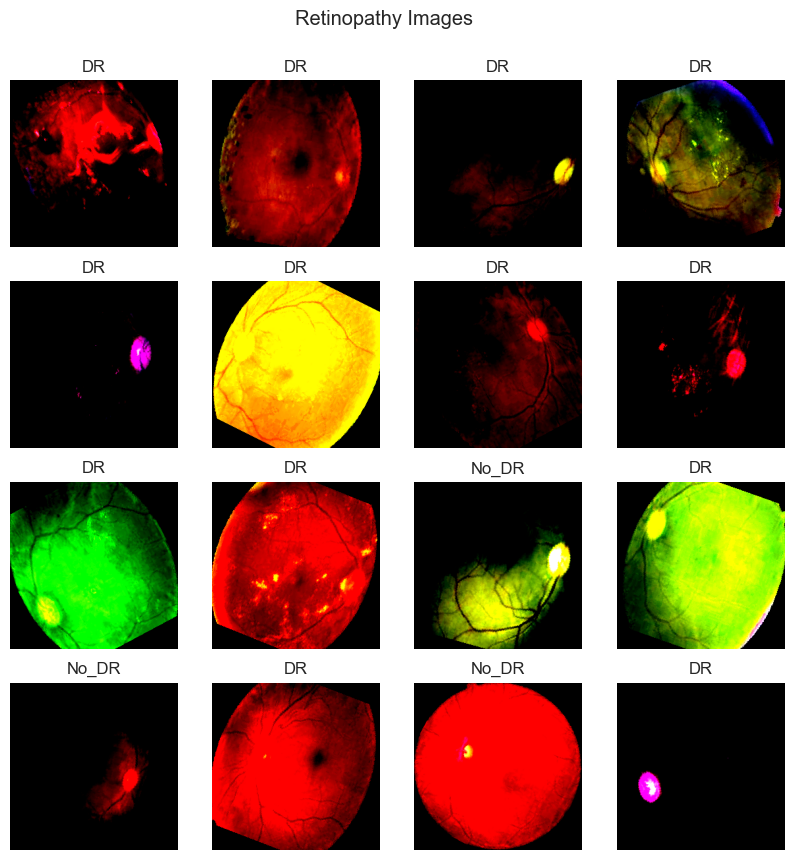

In [5]:
# Visualizing some images from Train set
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()

In [6]:
# Import and load Train, Validation and Test set
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

In [7]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64



In [8]:
'''This function can be useful in determining the output size of a convolutional layer,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [9]:
# Define Architecture For Retinopathy Model
class CNN_Retino(nn.Module):
    
    def __init__(self, params):
        
        super(CNN_Retino, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # CNN Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [10]:
params_model={
        "shape_in": (3,255,255), 
        "initial_filters": 16,    
        "num_fc1": 200,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
Retino_model = CNN_Retino(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

In [11]:
# Model Summary for CNN_Retino
summary(Retino_model, input_size=(3, 255, 255),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 253, 253]             448
            Conv2d-2         [-1, 32, 124, 124]           4,640
            Conv2d-3           [-1, 64, 60, 60]          18,496
            Conv2d-4          [-1, 128, 28, 28]          73,856
            Linear-5                  [-1, 200]       5,017,800
            Linear-6                    [-1, 2]             402
Total params: 5,115,642
Trainable params: 5,115,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.74
Forward/backward pass size (MB): 14.09
Params size (MB): 19.51
Estimated Total Size (MB): 34.35
----------------------------------------------------------------


In [12]:
loss_func = nn.NLLLoss(reduction="sum")

In [13]:
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [14]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [15]:
def train_val(model, params, verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # history of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize the best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [16]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,
 "val": val_loader,
 "epochs": 100,
 "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=True),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: >

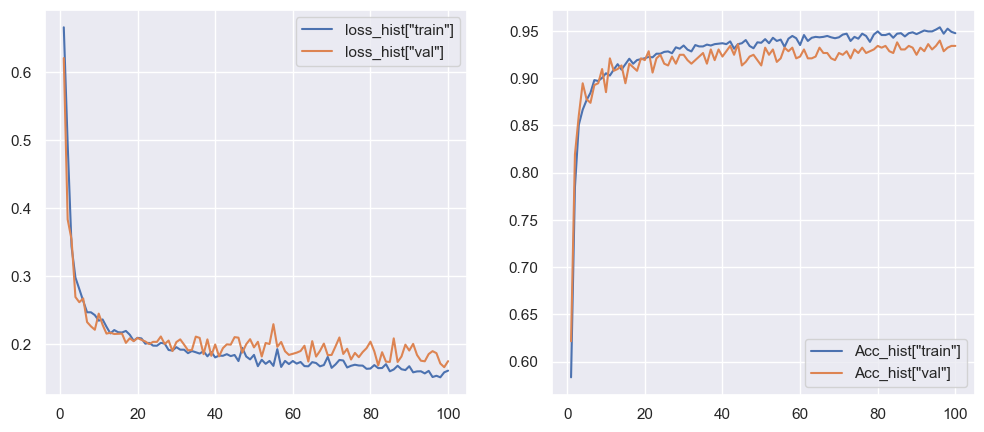

In [17]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

In [18]:
# Define Function For Classification Report
def ture_and_pred_val(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

In [19]:
# Classification Report for Retinopathy Classification Model based on Train Set
y_true, y_pred = ture_and_pred_val(train_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      1050
         1.0       0.95      0.96      0.95      1026

    accuracy                           0.95      2076
   macro avg       0.95      0.95      0.95      2076
weighted avg       0.95      0.95      0.95      2076
 




In [20]:
# # Classification Report for Retinopathy Classification Model based on Validation Set
y_true, y_pred = ture_and_pred_val(val_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       245
         1.0       0.94      0.95      0.94       286

    accuracy                           0.94       531
   macro avg       0.94      0.94      0.94       531
weighted avg       0.94      0.94      0.94       531
 




In [21]:
torch.save(Retino_model, "Retino_model.pt")

In [22]:
# Load the pretrained model
model = torch.load("Retino_model.pt")

# Move the model to the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Iterate over the test loader for prediction
with torch.no_grad():
    for images, _ in test_loader:
        
        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        
        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())

Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted cl

In [23]:
## Classification Report for Retinopathy Classification Model based on a Test set
y_true, y_pred = ture_and_pred_val(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       113
         1.0       0.91      0.95      0.93       118

    accuracy                           0.93       231
   macro avg       0.93      0.93      0.93       231
weighted avg       0.93      0.93      0.93       231
 




              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       113
         1.0       0.94      0.97      0.95       118

    accuracy                           0.95       231
   macro avg       0.95      0.95      0.95       231
weighted avg       0.95      0.95      0.95       231



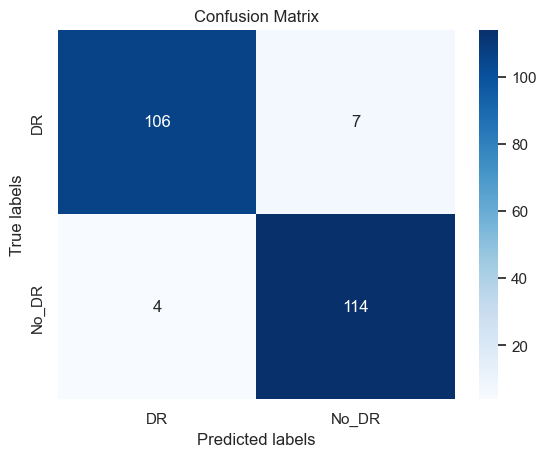

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_true, y_pred = ture_and_pred_val(test_loader, model)
labels = ['DR', 'No_DR']
print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, labels)